# Compare clustering using finite mixture vs DP mixture of Gaussians

In [18]:
try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from probml_utils.dp_mixgauss_utils import NormalInverseWishart, gmm_gibbs, dp_mixgauss_gibbs

import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

In [2]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [3]:
dim = 2
concentration = 1.0
n_data = 300
n_gibbs_samples = 1000
burn_in = 200
mean_precisions = [0.01, 0.5]
n_clusters_true = 4
n_clusters_input = [2, 4, 6]

In [6]:
data_set = {}
samples_set = {}
for m_precision in mean_precisions:
    print(f"Example with the precision parameter of the NIW prior being {m_precision}.")
    print("Generating data ...")
    # Generating the true data from a finite mixture model
    key = random.PRNGKey(0)
    key, *subkeys = random.split(key, 4)
    niw_params = dict(loc=jnp.zeros(dim), mean_precision=m_precision, df=dim + 5, scale=jnp.eye(dim))
    niw = NormalInverseWishart(**niw_params)
    cluster_weights = random.dirichlet(subkeys[0], 5.0 * jnp.ones(n_clusters_true))
    # cluster assignment of each datum
    cluster_indices = random.categorical(subkeys[1], jnp.log(cluster_weights), shape=(n_data,))
    cluster_params = niw.sample(seed=subkeys[2], sample_shape=(n_clusters_true,))
    cluster_covs = cluster_params["Sigma"]
    cluster_means = cluster_params["mu"]
    # data
    mean_per_datum = cluster_means[cluster_indices]
    cov_per_datum = cluster_covs[cluster_indices]
    key, *subkeys = random.split(key, n_data + 1)
    data = vmap(random.multivariate_normal, in_axes=(0, 0, 0))(jnp.array(subkeys), mean_per_datum, cov_per_datum)
    data_set[f"data_{str(m_precision).split('.')[0]}p{str(m_precision).split('.')[1]}"] = data

    print("Begin clustering via...")
    # Clustering via finite mixture model
    for n_clusters in n_clusters_input:
        print(f"finite mixture model with K = {n_clusters};")
        gmm_samples = gmm_gibbs(key, burn_in + n_gibbs_samples, data, concentration, n_clusters, niw_params)
        gmm_samples = gmm_samples[burn_in:]
        samples_set[f"gmm_{n_clusters}_data_{str(m_precision).split('.')[0]}p{str(m_precision).split('.')[1]}"] = gmm_samples

    # Clustering via DP mixture model
    print(f"DP mixture model.")
    dp_samples = dp_mixgauss_gibbs(key, burn_in + n_gibbs_samples, data, concentration, niw_params)
    dp_samples = dp_samples[burn_in:]
    samples_set[f"dp_data_{str(m_precision).split('.')[0]}p{str(m_precision).split('.')[1]}"] = dp_samples
    print("Finish clustering.")

Example with the precision parameter of the NIW prior being 0.01.
Generating data ...
Begin clustering via...
finite mixture model with K = 2;
finite mixture model with K = 4;
finite mixture model with K = 6;
DP mixture model.


/usr/local/lib/python3.7/dist-packages/jax/_src/ops/scatter.py:90: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  FutureWarning)


Finish clustering.
Example with the precision parameter of the NIW prior being 0.5.
Generating data ...
Begin clustering via...
finite mixture model with K = 2;
finite mixture model with K = 4;
finite mixture model with K = 6;
DP mixture model.


/usr/local/lib/python3.7/dist-packages/jax/_src/ops/scatter.py:90: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  FutureWarning)


Finish clustering.


(DeviceArray([0, 1], dtype=int32), DeviceArray([203,  97], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(DeviceArray([0, 1, 2], dtype=int32), DeviceArray([ 23,  72, 205], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(DeviceArray([1, 2, 4, 5], dtype=int32), DeviceArray([ 21,  36, 171,  72], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(DeviceArray([0, 3, 4, 5], dtype=int32), DeviceArray([ 22,  72,  29, 177], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(DeviceArray([0, 1], dtype=int32), DeviceArray([  8, 292], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(DeviceArray([0, 2, 3], dtype=int32), DeviceArray([  1, 237,  62], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(DeviceArray([1, 2, 3, 4, 5], dtype=int32), DeviceArray([250,  31,   3,  12,   4], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(DeviceArray([0, 4, 5], dtype=int32), DeviceArray([  1,  11, 288], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


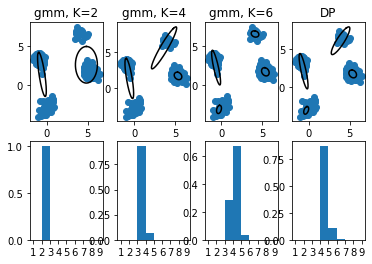

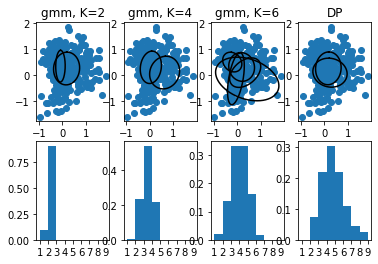

In [19]:
for data_key in data_set.keys():
    data = data_set[data_key]
    fig_col = 4
    fig_row = 2
    fig, axes = plt.subplots(2, fig_col)
    i = 0
    for sample_key in samples_set.keys():
        if sample_key.split('_')[-1] != data_key.split('_')[-1]:
            continue
        samples = samples_set[sample_key]
        final = samples[-1]
        print(jnp.unique(final, return_counts=True))
        # Plot the final cluster
        ax = axes[0, i]
        title = 'DP' if sample_key.split('_')[0] == 'dp' else "gmm, K="+sample_key.split('_')[1]
        ax.set_title(title)
        ax.scatter(data[:, 0], data[:, 1])
        final_clusters = samples[-1, :]
        for cluster_index in jnp.unique(final_clusters):
            subset = data[final_clusters == cluster_index, :]
            if subset.shape[0] == 1:
                continue
            mu = jnp.atleast_2d(jnp.mean(subset, axis=0)).T
            sig = sqrtm(np.cov(subset, rowvar=False))
            bb = jnp.arange(0, 2 * jnp.pi, 0.02)
            circ = mu.dot(jnp.ones((1, len(bb)))) + sig.dot(jnp.vstack([jnp.sin(bb), jnp.cos(bb)]))
            ax.plot(circ[0, :], circ[1, :], linewidth=1.5, color="k")

        # Histogram of the frequences of number of clusters
        # returned by the Gibbs sampler
        ax = axes[1, i]
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        n_clusters = jnp.array([len(jnp.unique(s)) for s in samples])
        ax.hist(n_clusters, range = (1, 9), bins=8, density=True)
        i += 1

Display result in separate figures and save.

(DeviceArray([0, 1], dtype=int32), DeviceArray([203,  97], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


(DeviceArray([0, 1, 2], dtype=int32), DeviceArray([ 23,  72, 205], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84:

(DeviceArray([1, 2, 4, 5], dtype=int32), DeviceArray([ 21,  36, 171,  72], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84:

(DeviceArray([0, 3, 4, 5], dtype=int32), DeviceArray([ 22,  72,  29, 177], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84:

(DeviceArray([0, 1], dtype=int32), DeviceArray([  8, 292], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


(DeviceArray([0, 2, 3], dtype=int32), DeviceArray([  1, 237,  62], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


(DeviceArray([1, 2, 3, 4, 5], dtype=int32), DeviceArray([250,  31,   3,  12,   4], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84:

(DeviceArray([0, 4, 5], dtype=int32), DeviceArray([  1,  11, 288], dtype=int32))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


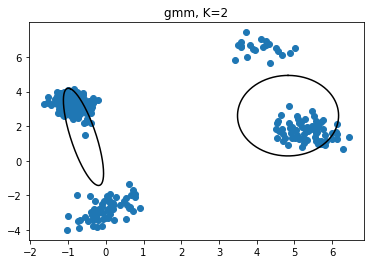

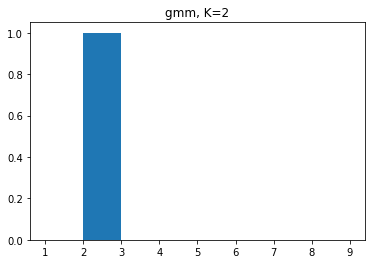

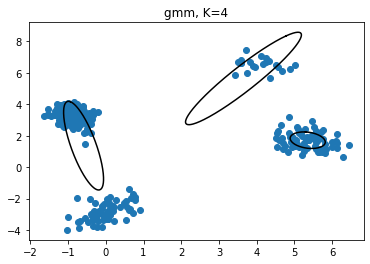

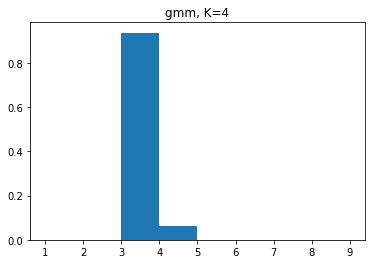

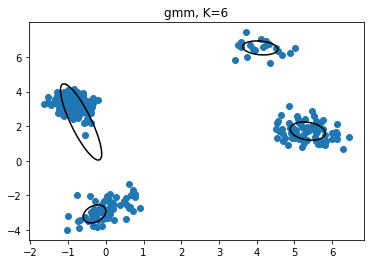

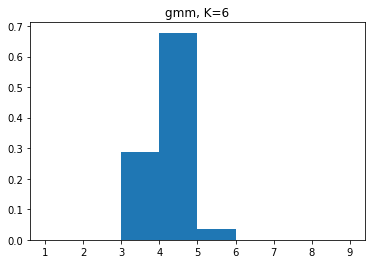

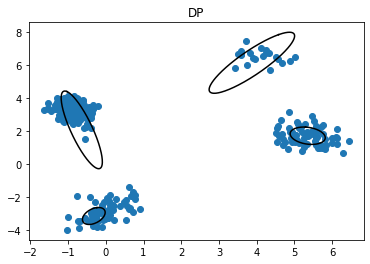

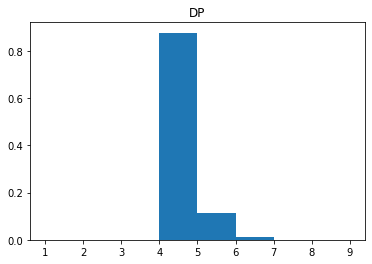

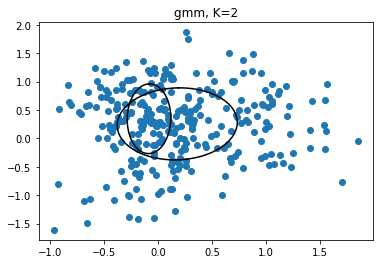

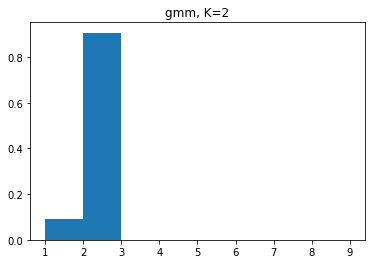

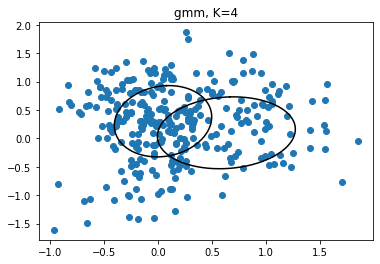

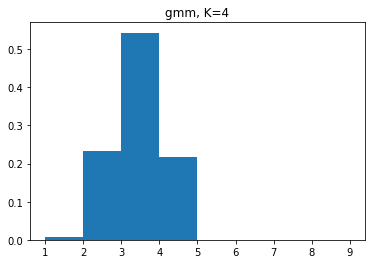

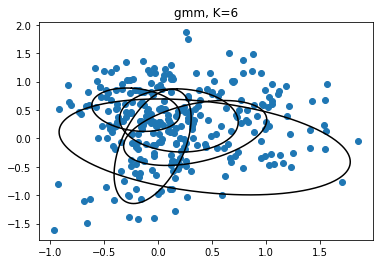

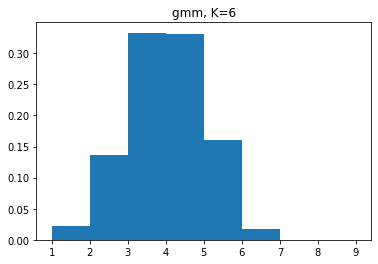

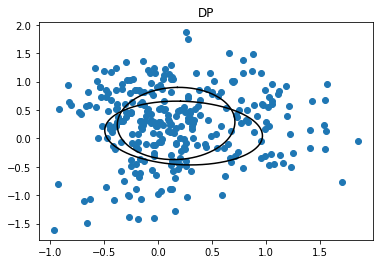

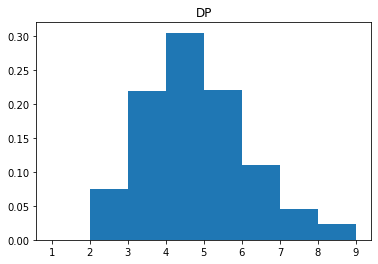

In [27]:
for sample_key in samples_set.keys():
    samples = samples_set[sample_key]
    data = data_set['_'.join(sample_key.split('_')[-2:])]
    final = samples[-1]
    print(jnp.unique(final, return_counts=True))
    # Plot the final cluster
    fig, ax = plt.subplots()
    title = 'DP' if sample_key.split('_')[0] == 'dp' else "gmm, K="+sample_key.split('_')[1]
    ax.set_title(title)
    ax.scatter(data[:, 0], data[:, 1])
    final_clusters = samples[-1, :]
    for cluster_index in jnp.unique(final_clusters):
        subset = data[final_clusters == cluster_index, :]
        if subset.shape[0] == 1:
            continue
        mu = jnp.atleast_2d(jnp.mean(subset, axis=0)).T
        sig = sqrtm(np.cov(subset, rowvar=False))
        bb = jnp.arange(0, 2 * jnp.pi, 0.02)
        circ = mu.dot(jnp.ones((1, len(bb)))) + sig.dot(jnp.vstack([jnp.sin(bb), jnp.cos(bb)]))
        ax.plot(circ[0, :], circ[1, :], linewidth=1.5, color="k")
        fname = "dp_mixgauss_cluster_" + sample_key + "_scatter"
        pml.savefig(fname)

    # Histogram of the frequences of number of clusters
    # returned by the Gibbs sampler
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    n_clusters = jnp.array([len(jnp.unique(s)) for s in samples])
    ax.hist(n_clusters, range = (1, 9), bins=8, density=True)
    fname = "dp_mixgauss_cluster_" + sample_key + "_histogram"
    pml.savefig(fname)